# Predictive Analysis on Extrovert vs Introvert Dataset
## Problem Type: Classification
### Dataset: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data

## Preprocessing

In [496]:
import pandas as pd
import numpy as np

df = pd.read_csv("personality_dataset.csv")

df['Personality_encoded'] = df['Personality'].map({'Introvert': 1, 'Extrovert': 0})
df['Stage_fear_encoded'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing_encoded'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

df = df.drop(['Personality', 'Drained_after_socializing', 'Stage_fear'], axis='columns')
df = df.drop_duplicates()
df = df.dropna()

print(df)

      Time_spent_Alone  Social_event_attendance  Going_outside  \
0                  4.0                      4.0            6.0   
1                  9.0                      0.0            0.0   
2                  9.0                      1.0            2.0   
3                  0.0                      6.0            7.0   
4                  3.0                      9.0            4.0   
...                ...                      ...            ...   
2888               5.0                      0.0            1.0   
2889               6.0                      0.0            0.0   
2896               3.0                      8.0            3.0   
2897               4.0                      1.0            1.0   
2899               3.0                      6.0            6.0   

      Friends_circle_size  Post_frequency  Personality_encoded  \
0                    13.0             5.0                    0   
1                     0.0             3.0                    1   
2        

### Checking for low variance features
#### They don't help the model learn, can add noise, increase computational cost and hurt performance.

In [497]:
low_variance_cols = df.loc[:, df.std(numeric_only=True) < 0.1].columns.tolist()
print(low_variance_cols)

[]


### Splitting the model into test and train

In [498]:
from sklearn.model_selection import train_test_split

X, y = df.drop(['Personality_encoded'], axis=1), df['Personality_encoded']

X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

### Checking to see if the target feature is imbalanced

In [499]:
# Checking to see if the target is imbalanced

y.value_counts(normalize=True)

Personality_encoded
0    0.57245
1    0.42755
Name: proportion, dtype: float64

### Checking Models and Hypertuning

In [500]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('model', SVC()) # Placeholder - will be replaced by GridSearchCV
])

param_grid = [
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, None]
    },
    {
        'model': [xgb.XGBClassifier(eval_metric='logloss', random_state=42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.1, 0.01]
    },
    {
        'model': [SVC(random_state=42, probability=True)],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    }
]

# Checking all models
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Viewing the best model and parameters
print(f"Best model: {grid.best_estimator_}")
print(f"Best score: {grid.best_score_:.4f}")

# Setting the model based on GridSearchCV
model = grid.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best model: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                  

## Evaluating the model

### ROC Curve
#### This is used to evaluate the performance of a binary classification model. It helps to evaluate how well this model can separate between extrovert and introvert.

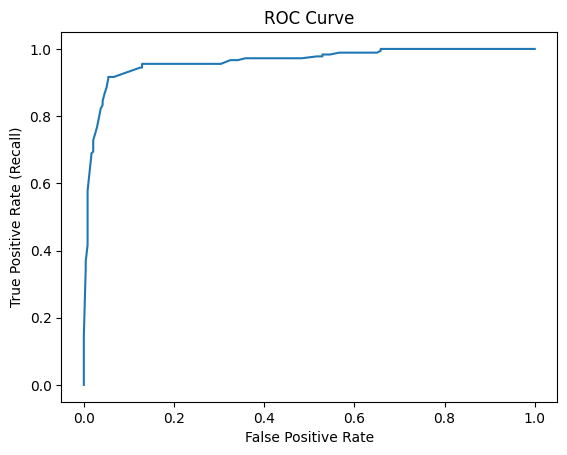

AUC Score: 0.9627


In [501]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict_proba(X_test)[:,1]

# fpr = false positive rate, tpr = true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.show()

auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}") # Closer to one means a more perfect classifier, below 0.5 means random. Shows how confident the model is in the predictions.

### Checking Classification Report

In [502]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       240
           1       0.93      0.92      0.92       180

    accuracy                           0.93       420
   macro avg       0.93      0.93      0.93       420
weighted avg       0.93      0.93      0.93       420



### Feature Importances
#### Checking for the most important features

In [503]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

feature_names = df.columns

# Sequential feature selection
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5)
sfs.fit(X, y)

# Get feature names and selection mask
all_features = X.columns
selected_mask = sfs.get_support()
selected_features = all_features[selected_mask]

print("Most important features: ", list(selected_features))

Most important features:  ['Friends_circle_size', 'Stage_fear_encoded', 'Drained_after_socializing_encoded']


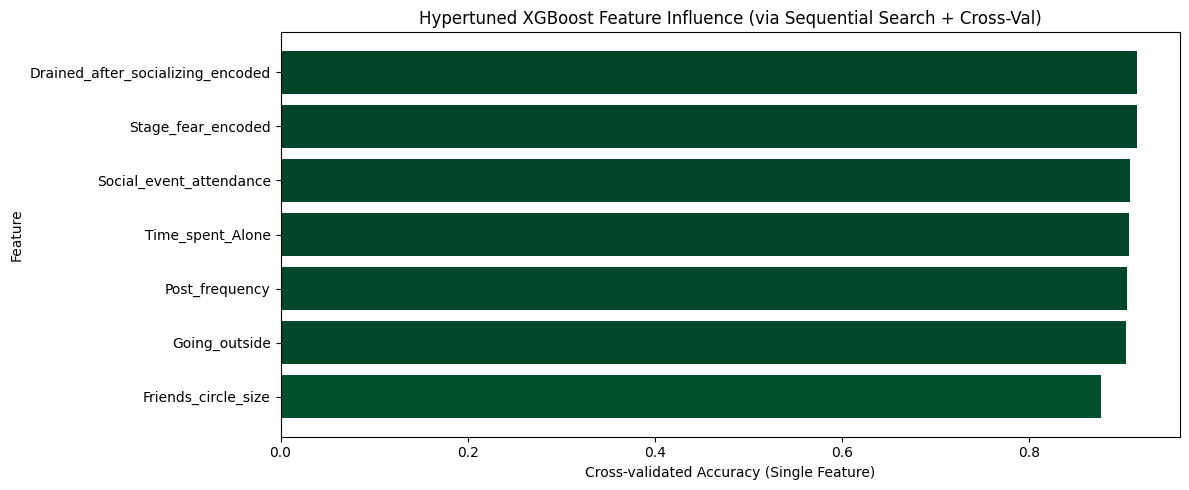

In [504]:
# Scoring each feature to simulate importance
feature_scores = []
for feature in all_features:
    score = cross_val_score(model, X[[feature]], y, cv=5).mean()
    feature_scores.append(score)

# Normalizing scores for visualization
feature_scores = np.array(feature_scores)
sorted_index = np.argsort(feature_scores)
sorted_features = all_features[sorted_index]
sorted_scores = feature_scores[sorted_index]

# Plotting
colors = plt.cm.YlGn(sorted_scores / sorted_scores.max())
plt.figure(figsize=(12,5))
plt.barh(sorted_features, sorted_scores, color=colors)
plt.xlabel("Cross-validated Accuracy (Single Feature)")
plt.ylabel('Feature')
plt.title("Hypertuned XGBoost Feature Influence (via Sequential Search + Cross-Val)")
plt.tight_layout()
plt.show()

<Axes: >

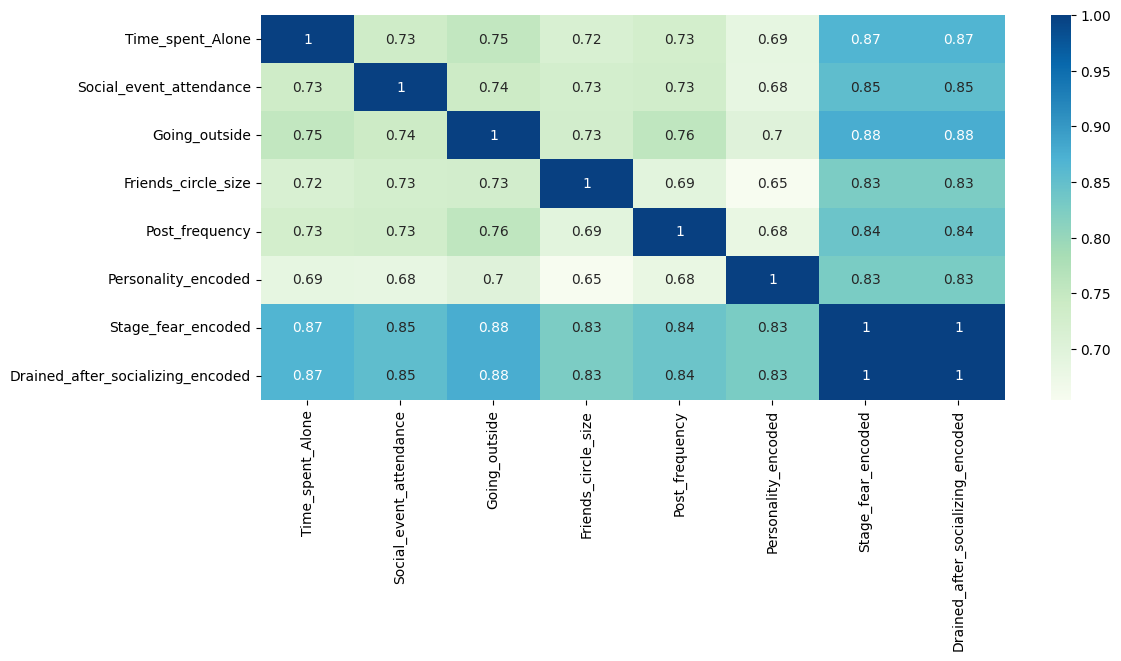

In [505]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.heatmap(abs(df.corr()), annot=True, cmap='GnBu')

## Making Predictions to Test the Model
#### Based on my answers

In [512]:
new_data = pd.DataFrame([{
    'Time_spent_Alone': 9.0,
    'Social_event_attendance': 0.0,
    'Going_outside': 0.5,
    'Friends_circle_size': 4,
    'Post_frequency': 1,
    'Stage_fear_encoded': 1,
    'Drained_after_socializing_encoded': 1
}])

# Predicting
prediction = model.predict(new_data)
print("Prediction: ", prediction)

# It correctly predicts I'm an introvert

Prediction:  [1]
